#Import Libraries


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
import random

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

#Data Processing

In [ ]:
#Data Loading
file_name = r"/content/2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(file_name)

#Get the lists of sheet names which are companies' names
Comp_names = xlsx.sheet_names


# Create an empty list to store dataframes
dataframes = []

# Loop through each sheet and store data in dataframes list
for company in Comp_names:
    df = xlsx.parse(company, skipfooter=1)  # Load the sheet into a dataframe
    df['Company'] = company  # Add a column to identify the company
    dataframes.append(df)  # Append the dataframe to the list


# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes[:2], ignore_index=True)

In [ ]:
combined_df.head()


,Date,Price,Open,High,Low,Vol.,Change %,Company
0,2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.0076,Russia - Sberbank Rossii PAO (S
1,2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.0002,Russia - Sberbank Rossii PAO (S
2,2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.0071,Russia - Sberbank Rossii PAO (S
3,2021-03-26,291.22,288.63,292.75,288.32,56.07M,0.0159,Russia - Sberbank Rossii PAO (S
4,2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.0030,Russia - Sberbank Rossii PAO (S


In [ ]:
combined_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Company
621,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.0005,Turkey - Koc Holding AS (KCHOL)
622,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.0075,Turkey - Koc Holding AS (KCHOL)
623,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-0.0108,Turkey - Koc Holding AS (KCHOL)
624,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.0039,Turkey - Koc Holding AS (KCHOL)
625,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.0030,Turkey - Koc Holding AS (KCHOL)


In [ ]:
#data structure
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      626 non-null    datetime64[ns]
 1   Price     626 non-null    float64       
 2   Open      626 non-null    float64       
 3   High      626 non-null    float64       
 4   Low       626 non-null    float64       
 5   Vol.      626 non-null    object        
 6   Change %  626 non-null    float64       
 7   Company   626 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 39.2+ KB


In [ ]:
#statistical analysis
combined_df.describe()

,Price,Open,High,Low,Change %
count,626.000000,626.000000,626.000000,626.000000,626.000000
mean,125.498482,125.456805,127.030304,123.804473,0.000407
std,110.765726,110.699657,111.991476,109.340270,0.023083
min,12.790000,12.970000,13.110000,12.380000,-0.099400
25%,17.580000,17.617500,17.852500,17.435000,-0.012000
50%,23.630000,23.660000,24.240000,23.350000,0.000650
75%,228.597500,228.970000,231.637500,226.265000,0.014225
max,293.300000,294.860000,296.070000,291.500000,0.129000


**Data Cleaning**

Handle missing values.

Ensure data consistency (e.g., stock prices should be non-negative).




In [ ]:
#check the number of missing values for each column
missing_values = combined_df.isnull().sum()
print(missing_values)


Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Company     0
dtype: int64


No missing Values in the data set

From the statistical analysis,no price have a negative value

In [ ]:
# Convert 'Vol.' column to a consistent format
def volume_conversion(vol):
    if 'M' in vol:
        return float(vol.replace('M', '')) * 1_000_000
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1_000
    elif vol == '-':
        return None  # Convert '-' to NaN
    else:
        return float(vol)

combined_df['Vol.'] = combined_df['Vol.'].astype(str).apply(volume_conversion)

combined_df['Vol.']


0      47000000.0
1      38810000.0
2      43680000.0
3      56070000.0
4      35220000.0
          ...    
621     2790000.0
622     2890000.0
623     1940000.0
624     3310000.0
625     2530000.0
Name: Vol., Length: 626, dtype: float64

In [ ]:
# Convert 'Change %' to a float
# (remove the '%' sign and divide by 100)
combined_df['Change '] = combined_df['Change %'].astype(str).str.rstrip('%').astype('float')/ 100.0
combined_df['Change ']

0     -0.000076
1     -0.000002
2      0.000071
3      0.000159
4      0.000030
         ...   
621    0.000005
622   -0.000075
623   -0.000108
624   -0.000039
625    0.000030
Name: Change , Length: 626, dtype: float64

#Exploratory Data Analysis

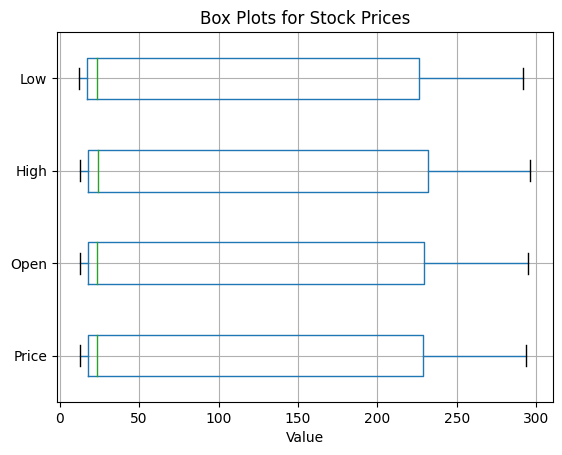

In [ ]:
#plotting a box plot
combined_df.boxplot(column=['Price', 'Open', 'High', 'Low'], vert=False)
plt.title('Box Plots for Stock Prices')
plt.xlabel('Value')
plt.show()

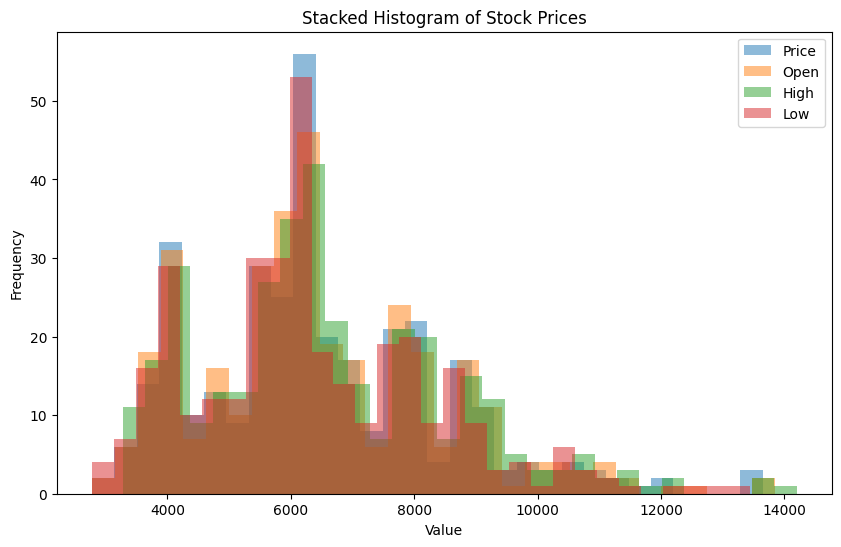

In [ ]:
#Visualization

numeric_columns = ['Price', 'Open', 'High', 'Low']

# Create a stacked histogram
plt.figure(figsize=(10, 6))
for column in numeric_columns:
    plt.hist(df[column], bins=30, alpha=0.5, label=column)

plt.title('Stacked Histogram of Stock Prices')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

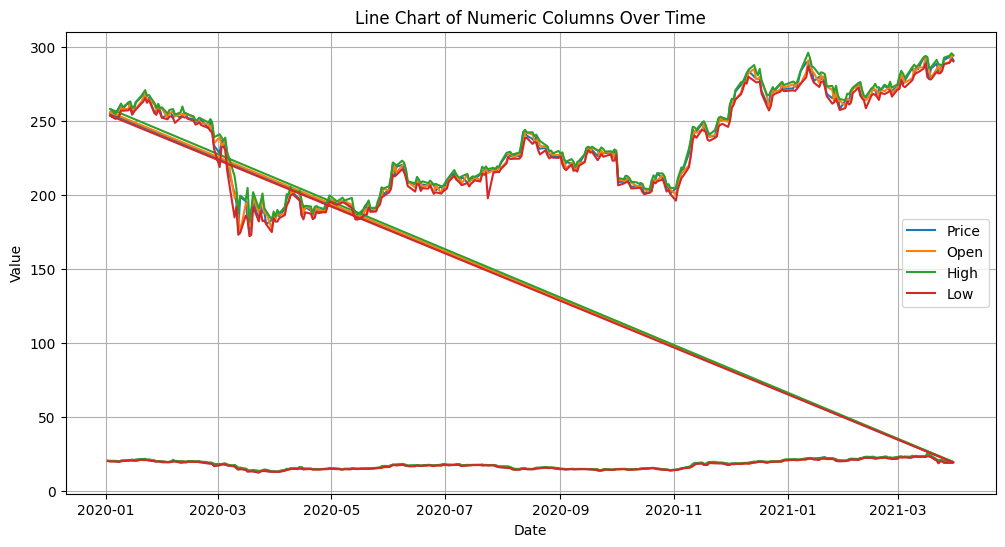

In [ ]:
#line chart
# Set the 'Date' column as the index
combined_df.set_index('Date', inplace=True)

# List of numerical columns to plot
columns_to_plot = ['Price', 'Open', 'High', 'Low']

# Create line charts for each column
plt.figure(figsize=(12, 6))
for column in columns_to_plot:
    plt.plot(combined_df.index, combined_df[column], label=column)

# Customize the plot
plt.title('Line Chart of Numeric Columns Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

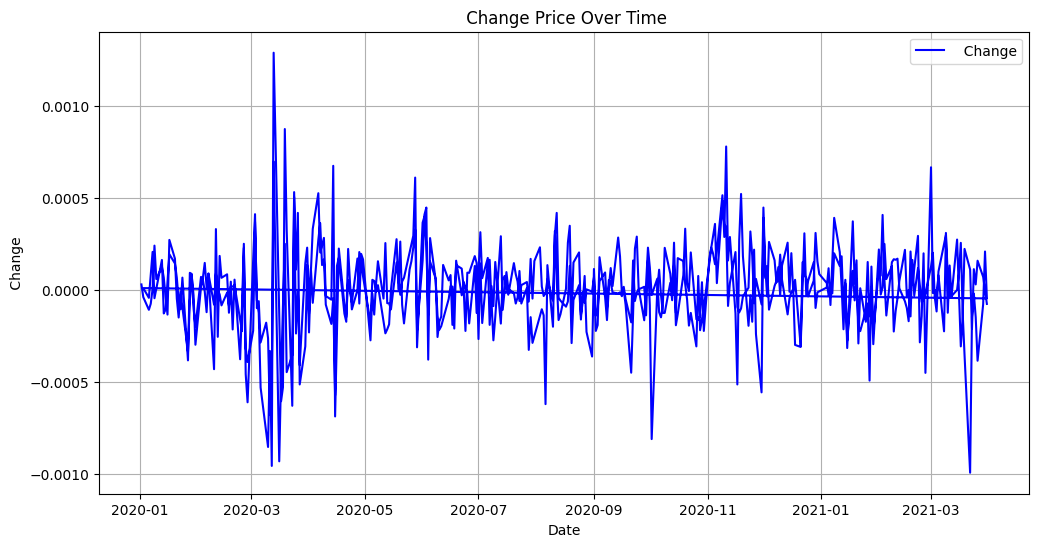

In [ ]:
columns=['Price','Open','High','Low']
# Create a line chart for percentage changes
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Change '], label=f'  Change', color='blue')

# Customize the plot
plt.title(f' Change Price Over Time')
plt.xlabel('Date')
plt.ylabel(' Change ')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Data Scaling



In [ ]:
# Data Preprocessing Function
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(scaled_data)):  # Using a window of 60 days
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

#Feature Engineering

**Moving averages**

A moving average is  used as a statistical calculation in time-series analysis and data analysis in general. It is used to smooth out fluctuations in data and identify trends or patterns over time.

Types of moving averages, including the simple moving average (SMA) and the exponential moving average (EMA).



In [ ]:
combined_df.reset_index(inplace=True)

Simple Moving average

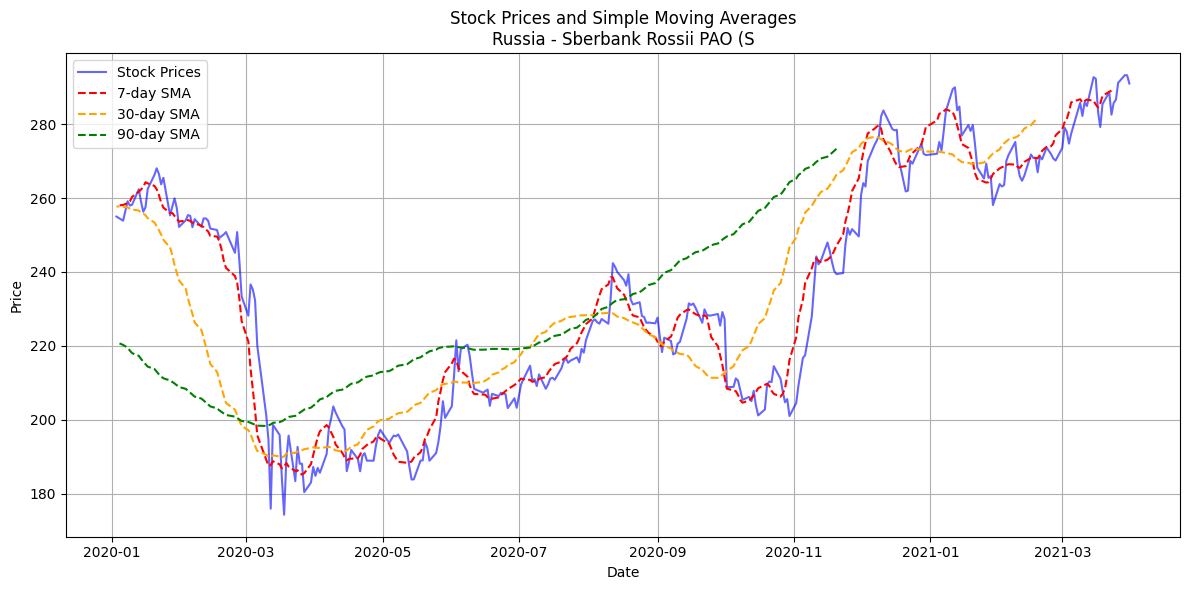

In [ ]:
# The 7-day Simple Moving Average (SMA)
combined_df['7_SMA'] = combined_df['Price'].rolling(window=7).mean()

# The 30-day Simple Moving Average (SMA)
combined_df['30_SMA'] = combined_df['Price'].rolling(window=30).mean()

# The 90-day Simple Moving Average (SMA)
combined_df['90_SMA'] = combined_df['Price'].rolling(window=90).mean()

# Select a specific company for visualization
selected_company = Comp_names[0]
company_df = combined_df[combined_df['Company'] == selected_company]
plt.figure(figsize=(12, 6))

# Plotting the stock prices
plt.plot(company_df['Date'], company_df['Price'], label='Stock Prices', color='blue', alpha=0.6)

# Plotting the 7-day moving average
plt.plot(company_df['Date'], company_df['7_SMA'], label='7-day SMA', color='red', linestyle='--')

# Plotting the 30-day moving average
plt.plot(company_df['Date'], company_df['30_SMA'], label='30-day SMA', color='orange', linestyle='--')

# Plotting the 90-day moving average
plt.plot(company_df['Date'], company_df['90_SMA'], label='90-day SMA', color='green', linestyle='--')

plt.title('Stock Prices and Simple Moving Averages'+'\n'+selected_company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

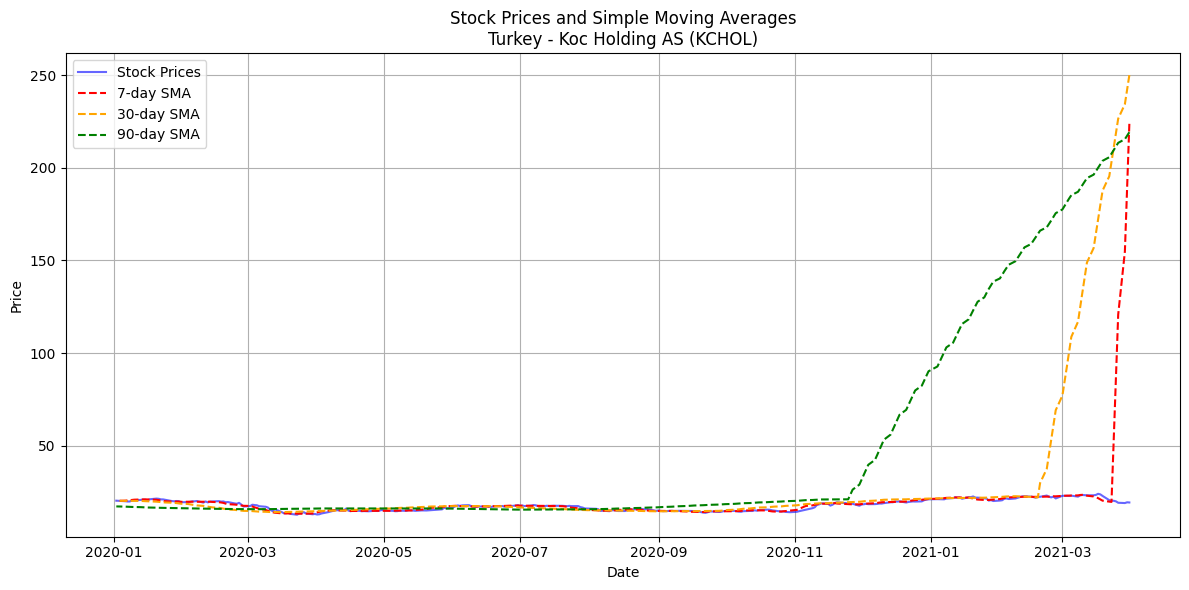

In [ ]:
# The 7-day Simple Moving Average (SMA)
combined_df['7_SMA'] = combined_df['Price'].rolling(window=7).mean()

# The 30-day Simple Moving Average (SMA)
combined_df['30_SMA'] = combined_df['Price'].rolling(window=30).mean()

# The 90-day Simple Moving Average (SMA)
combined_df['90_SMA'] = combined_df['Price'].rolling(window=90).mean()

# Select a specific company for visualization
selected_company1 = Comp_names[1]
company_df1 = combined_df[combined_df['Company'] == selected_company1]
plt.figure(figsize=(12, 6))

# Plotting the stock prices
plt.plot(company_df1['Date'], company_df1['Price'], label='Stock Prices', color='blue', alpha=0.6)

# Plotting the 7-day moving average
plt.plot(company_df1['Date'], company_df1['7_SMA'], label='7-day SMA', color='red', linestyle='--')

# Plotting the 30-day moving average
plt.plot(company_df1['Date'], company_df1['30_SMA'], label='30-day SMA', color='orange', linestyle='--')

# Plotting the 90-day moving average
plt.plot(company_df1['Date'], company_df1['90_SMA'], label='90-day SMA', color='green', linestyle='--')

plt.title('Stock Prices and Simple Moving Averages'+'\n'+selected_company1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Calculating the Bollinger Bands

The Bollinger Bands is a technical indicator that is plotted two standard deviations, both positively and negatively, away from a simple moving average (SMA) of a  price

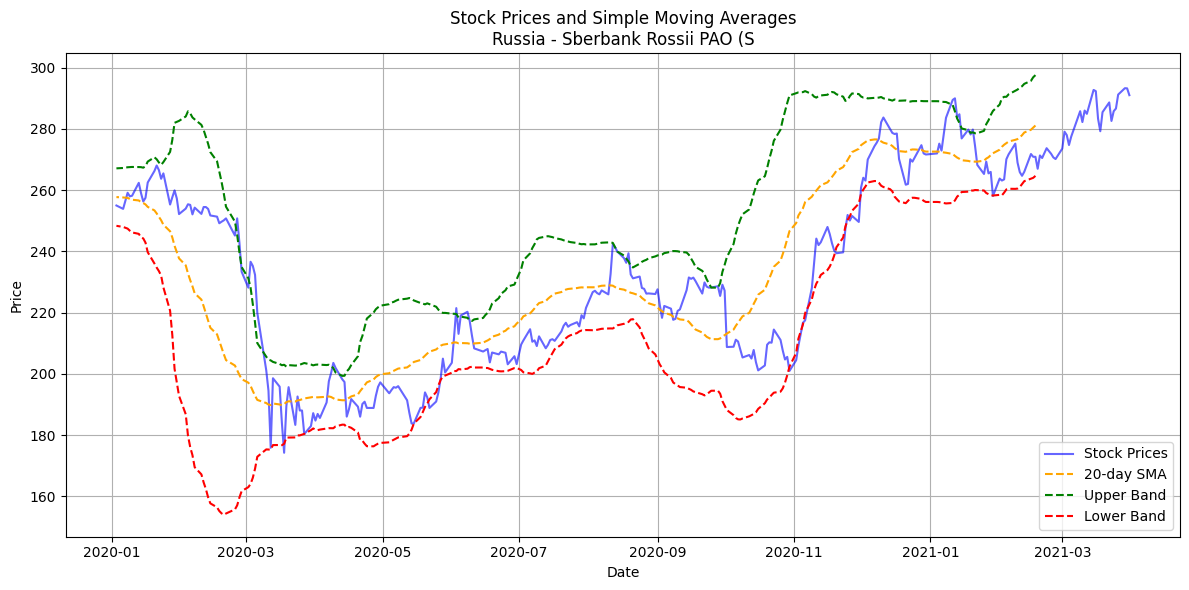

In [53]:
# The 20-day Simple Moving Average (SMA)
combined_df['20_SMA'] = combined_df['Price'].rolling(window=30).mean()
combined_df['20_Std'] = combined_df['Price'].rolling(window=30).std()

combined_df['upper_band'] = combined_df['20_SMA'] + (combined_df['20_Std']*2)
combined_df['lower_band'] = combined_df['20_SMA'] - (combined_df['20_Std']*2)

# Select a specific company for visualization
selected_company = Comp_names[0]
company_df = combined_df[combined_df['Company'] == selected_company]
plt.figure(figsize=(12, 6))

# Plotting the stock prices
plt.plot(company_df['Date'], company_df['Price'], label='Stock Prices', color='blue', alpha=0.6)



# Plotting the 20-day moving average
plt.plot(company_df['Date'], company_df['20_SMA'], label='20-day SMA', color='orange', linestyle='--')
plt.plot(company_df['Date'], company_df['upper_band'], label='Upper Band', color='green', linestyle='--')
plt.plot(company_df['Date'], company_df['lower_band'], label='Lower Band', color='red', linestyle='--')


plt.title('Bollinger and Simple Moving Averages'+'\n'+selected_company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Exponential Moving Average

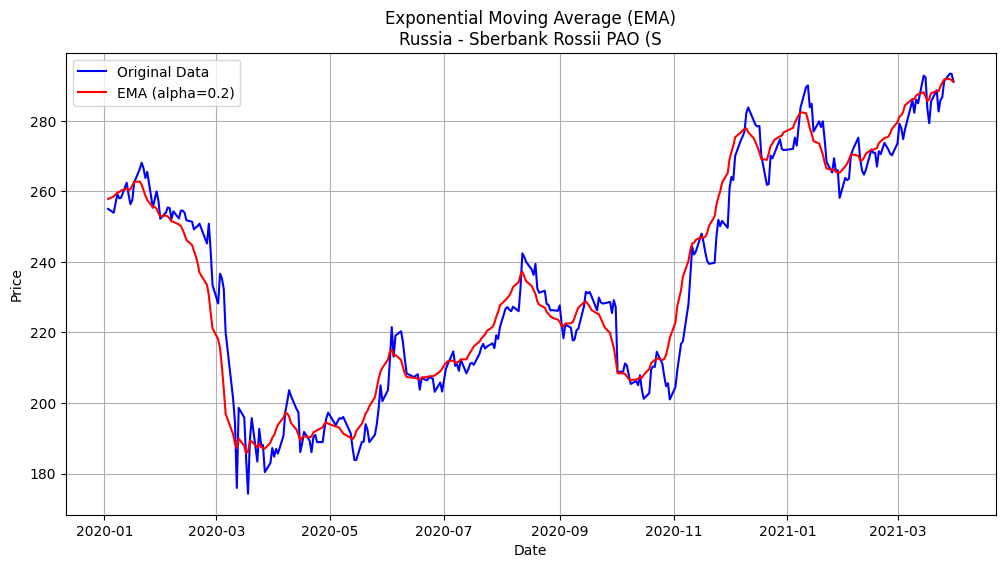

In [ ]:
alpha = 0.2
combined_df['EMA'] = combined_df['Price'].ewm(alpha=alpha, adjust=False).mean()

# Select a specific company for visualization
company_df = combined_df[combined_df['Company'] == selected_company]

# Create a plot to visualize the original data and the EMA
plt.figure(figsize=(12, 6))
plt.plot(company_df['Date'], company_df['Price'], label='Original Data', color='blue')
plt.plot(company_df['Date'], company_df['EMA'], label=f'EMA (alpha={alpha})', color='red')
plt.title('Exponential Moving Average (EMA)''\n'+selected_company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

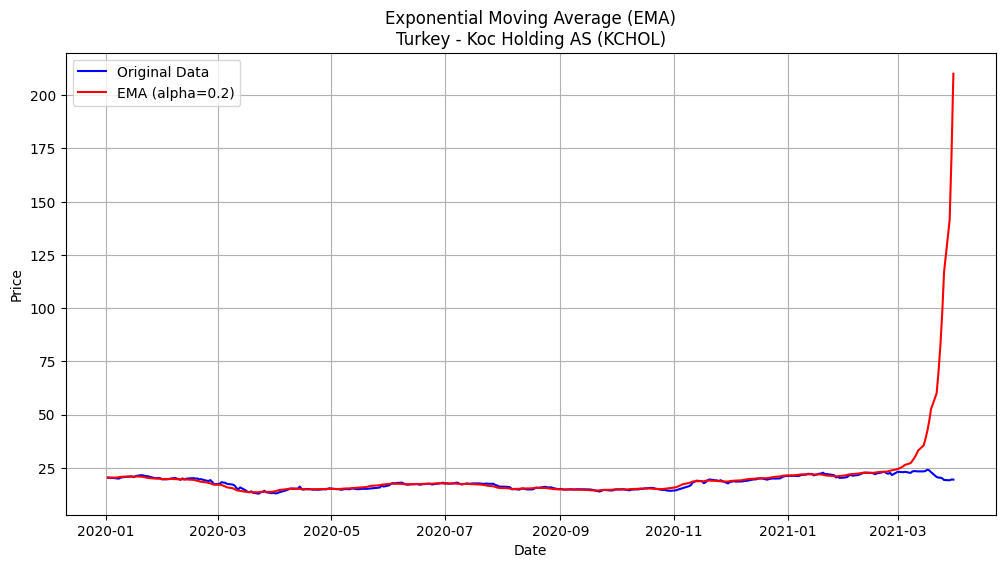

In [ ]:
alpha = 0.2
combined_df['EMA'] = combined_df['Price'].ewm(alpha=alpha, adjust=False).mean()

# Select a specific company for visualization
company_df1 = combined_df[combined_df['Company'] == selected_company1]

# Create a plot to visualize the original data and the EMA
plt.figure(figsize=(12, 6))
plt.plot(company_df1['Date'], company_df1['Price'], label='Original Data', color='blue')
plt.plot(company_df1['Date'], company_df1['EMA'], label=f'EMA (alpha={alpha})', color='red')
plt.title('Exponential Moving Average (EMA)''\n'+selected_company1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Relative Strength Index**



It measures the speed and change of price movements. RSI oscillates between zero and 100 and is typically used to identify overbought or oversold conditions.

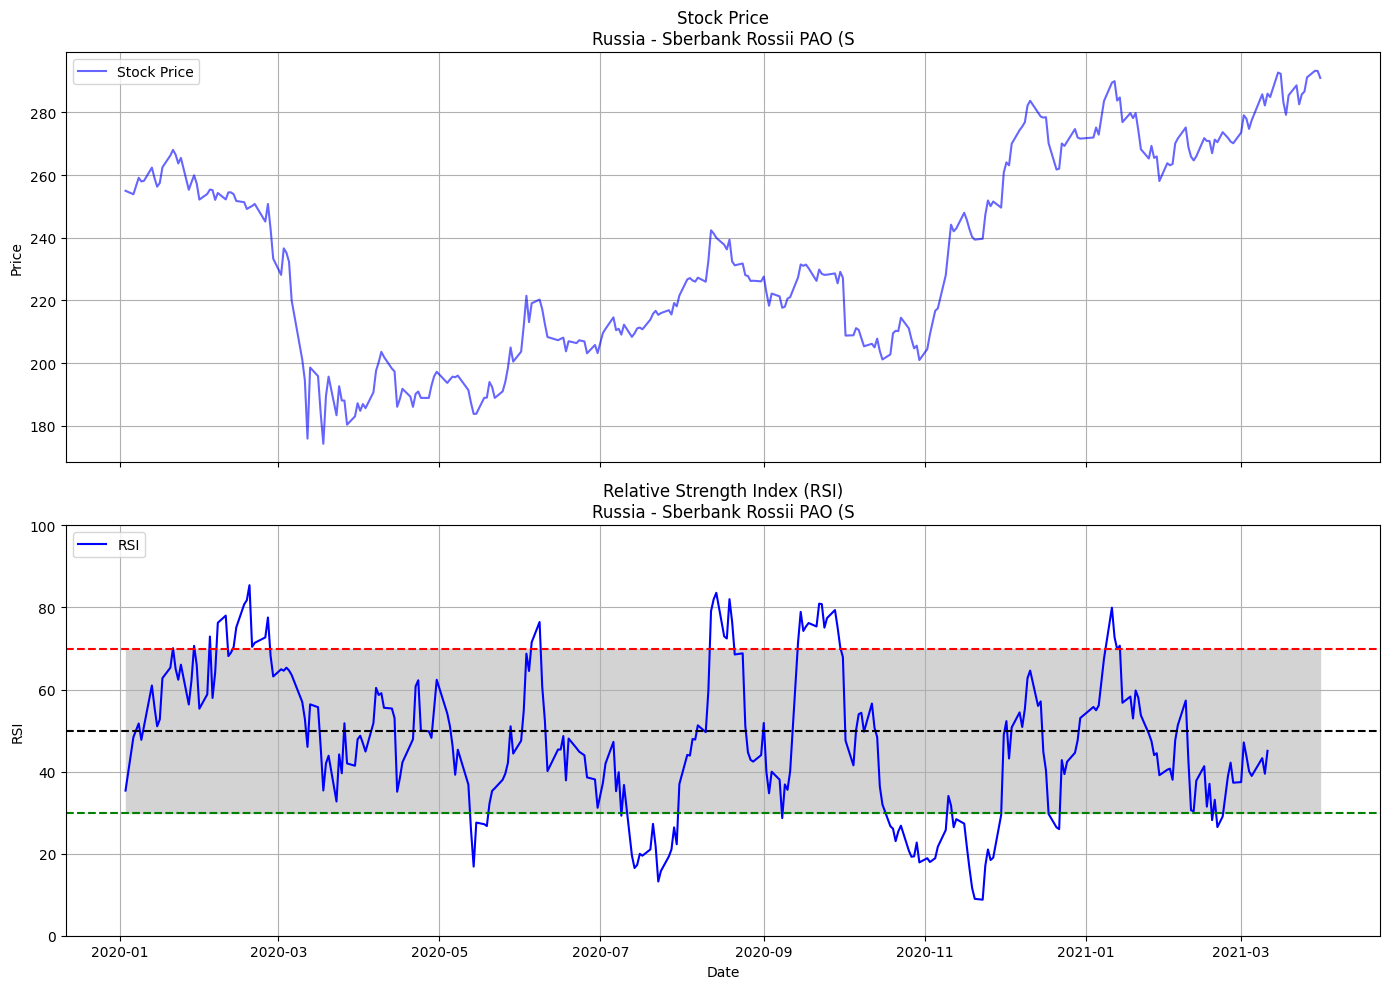

In [ ]:
#Define  RSI function
def rsi(data, window):
  delta = data.diff()
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0

  roll_up = up.rolling(window=window).mean()
  roll_down = down.abs().rolling(window=window).mean()

  RS = roll_up / roll_down
  RSI = 100.0 - (100.0 / (1.0 + RS))

  return RSI

combined_df['RSI'] = rsi(combined_df['Price'], 14)

# Select a specific company for visualization
company_df = combined_df[combined_df['Company'] == selected_company]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(company_df['Date'], company_df['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green', linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(company_df['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Relative Strength Index (RSI)'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


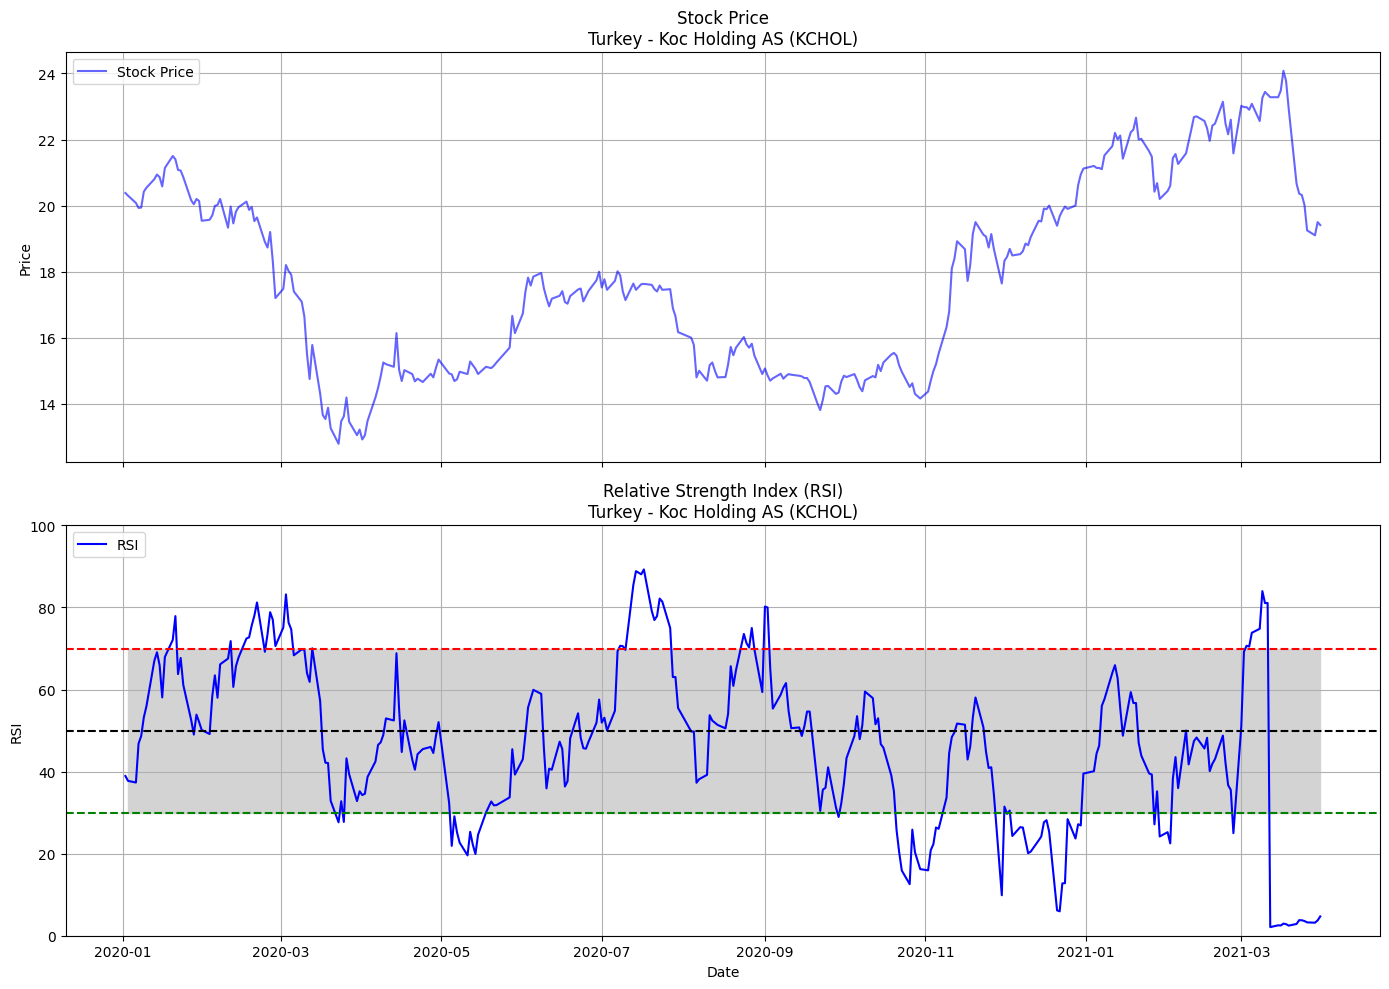

In [ ]:
#Define  RSI function
def rsi(data, window):
  delta = data.diff()
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0

  roll_up = up.rolling(window=window).mean()
  roll_down = down.abs().rolling(window=window).mean()

  RS = roll_up / roll_down
  RSI = 100.0 - (100.0 / (1.0 + RS))

  return RSI

combined_df['RSI'] = rsi(combined_df['Price'], 14)

# Select a specific company for visualization
company_df1 = combined_df[combined_df['Company'] == selected_company1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df1['Date'], company_df1['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company1)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(company_df1['Date'], company_df1['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green', linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(company_df['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Relative Strength Index (RSI)'+'\n'+selected_company1)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


**Moving Average Convergence Divergence**

Momentum indicator that shows the relationship between two moving averages.

It consists of two main components:

    MACD line
    Signal line

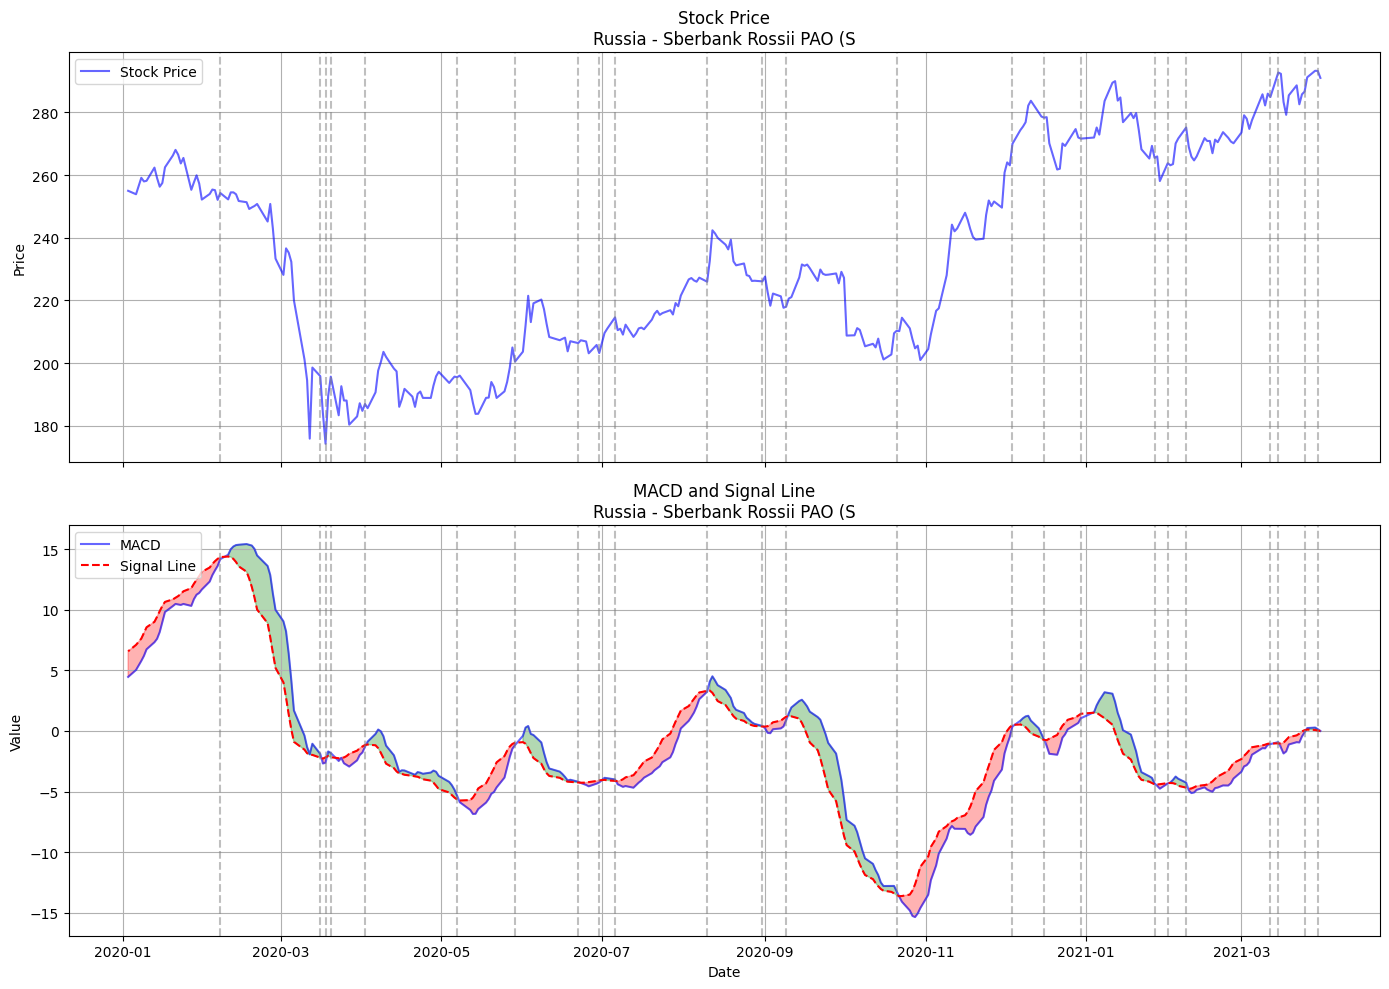

In [ ]:
# Calculate the Short Term Exponential Moving Average
combined_df['14_EMA'] = combined_df['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
combined_df['30_EMA'] = combined_df['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
combined_df['MACD'] = combined_df['14_EMA'] - combined_df['30_EMA']

# Calculate Signal Line
combined_df['Signal_Line'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()

# Select a specific company for visualization (for clarity)
company_df = combined_df[combined_df['Company'] == selected_company]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(company_df['Date'], company_df['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(company_df['Date'], company_df['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] > company_df['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] <= company_df['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((company_df['MACD'] > company_df['Signal_Line']) & (company_df['MACD'].shift(1) <= company_df['Signal_Line'].shift(1))) | ((company_df['MACD'] < company_df['Signal_Line']) & (company_df['MACD'].shift(1) >= company_df['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in company_df['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

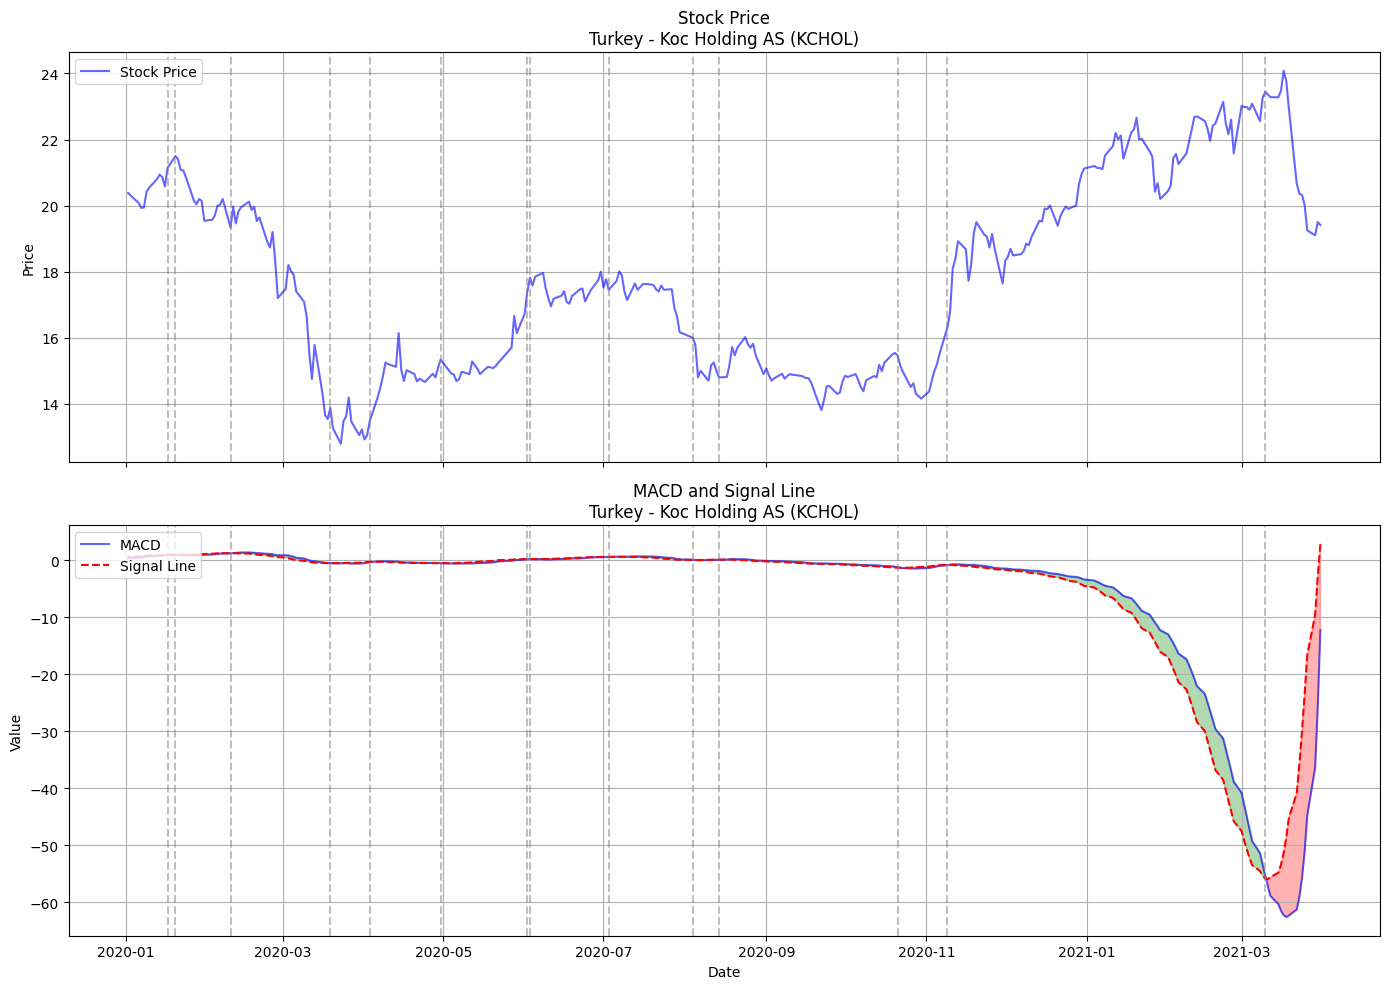

In [ ]:
# Calculate the Short Term Exponential Moving Average
combined_df['14_EMA'] = combined_df['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
combined_df['30_EMA'] = combined_df['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
combined_df['MACD'] = combined_df['14_EMA'] - combined_df['30_EMA']

# Calculate Signal Line
combined_df['Signal_Line'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()

# Select a specific company for visualization (for clarity)
company_df1 = combined_df[combined_df['Company'] == selected_company1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df1['Date'], company_df1['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company1)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(company_df1['Date'], company_df1['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(company_df1['Date'], company_df1['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(company_df1['Date'], company_df1['MACD'], company_df1['Signal_Line'], where=(company_df1['MACD'] > company_df1['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(company_df1['Date'], company_df1['MACD'], company_df1['Signal_Line'], where=(company_df1['MACD'] <= company_df1['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((company_df1['MACD'] > company_df1['Signal_Line']) & (company_df1['MACD'].shift(1) <= company_df1['Signal_Line'].shift(1))) | ((company_df1['MACD'] < company_df1['Signal_Line']) & (company_df1['MACD'].shift(1) >= company_df1['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in company_df1['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line'+'\n'+selected_company1)
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

ACF and PACF

<Figure size 1200x600 with 0 Axes>

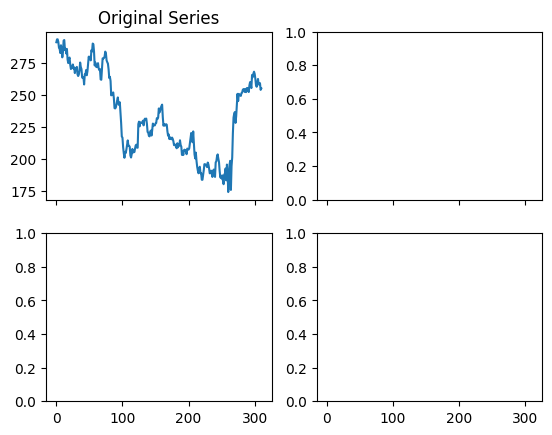

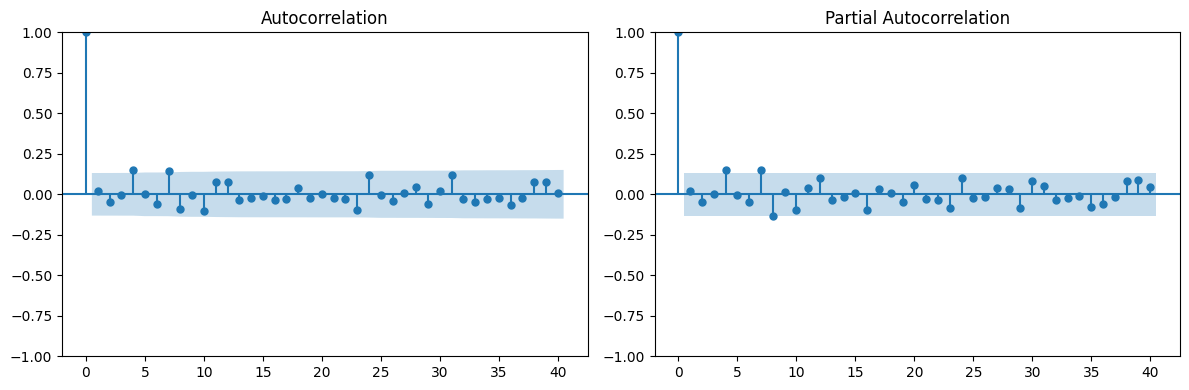

In [ ]:
# Select a specific company for analysis
selected_company = Comp_names[0]
company_df = combined_df[combined_df['Company'] == selected_company]
plt.figure(figsize=(12, 6))

company_df = combined_df[combined_df['Company'] == selected_company].copy()

# Original Series
fig, axes= plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(company_df.Price); axes[0, 0].set_title('Original Series')
#plot_acf(company_df.Price, ax=axes[0, 1])

# First differencing to make the series stationary
company_df['Price_Diff'] = company_df['Price'].diff()

# Drop NaN values introduced by differencing
company_df.dropna(inplace=True)

# Plot ACF and PACF to help decide on p and q
# Visual aid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(company_df['Price_Diff'], lags=40, ax=ax1)
plot_pacf(company_df['Price_Diff'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()

**Data Splitting**

Split data into training(2020) and testing (2021 Q1) sets

In [ ]:
# Split the data into training and test sets
train = combined_df[combined_df['Date'].dt.year == 2020]
test = combined_df[combined_df['Date'].dt.year == 2021]

#ARIMA-Model Development

**Model Selection**

Models like ARIMA, Prophet, LSTM, and other time series forecasting models can be considered.

Use cross-validation on the training set to tune hyperparameters.



In [ ]:
# Train and Test function, so that we can pass multiple companies .
def train_test_company(company_name, train, test, p, d, q):
    # Filter data for the given company and ensure it's sorted by date
    train_data = train[train['Company'] == company_name].sort_values(by='Date')
    test_data = test[test['Company'] == company_name].sort_values(by='Date')

    # Ensure the 'Date' column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Fit the ARIMA Model on the training data
    model = ARIMA(train_data['Price'], order=(p, d, q))
    results = model.fit()

    # Forecast the values for the test set duration
    forecast = results.forecast(steps=len(test_data))

    # Evaluate the model's performance
    mse = mean_squared_error(test_data['Price'], forecast)
    rmse = np.sqrt(mse)
    print(f"Company: {company_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the actual vs. predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data['Date'], train_data['Price'], label='Training Data', color='blue', alpha=0.6)
    plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data', color='green', alpha=0.6)
    plt.plot(test_data['Date'], forecast, label='ARIMA Forecast', color='red', linestyle='--')
    plt.title(f'ARIMA Model Forecast vs Actuals for {company_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Optimization function to determine pdq
def arima_grid_search_for_company(company_name, train, p_values, d_values, q_values):
    # Filter training data for the given company
    train_data = train[train['Company'] == company_name]['Price']

    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    results = model.fit()
                    # Check if the current model's AIC is lower than the previous best
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = order
                        best_model = results
                except:
                    continue

    return company_name, best_order, best_aic

In [ ]:
# Define the range of values for p, d, q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Initialize variables
saved_results = 0
desired_companies = 2 #first two companies

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Company', 'Best_Order', 'Best_AIC'])

# Loop through all companies and save the results in the DataFrame
for company in train['Company'].unique():
    company_name, best_order, best_aic = arima_grid_search_for_company(company, train, p_values, d_values, q_values)
    results_df.loc[len(results_df)] = [company_name, best_order, best_aic]

  #Increment the saved_results count
    saved_results += 1
    if saved_results >= desired_companies: # Check if have saved results for the desired number of companies and break out of the loop
       break

# Display the results
print(results_df)


                           Company Best_Order     Best_AIC
0  Russia - Sberbank Rossii PAO (S  (2, 1, 2)  1495.338825
1  Turkey - Koc Holding AS (KCHOL)  (0, 1, 0)   252.962985


**Model Training** and **Evaluation**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Russia - Sberbank Rossii PAO (S
Root Mean Squared Error (RMSE): 10.151046308631035


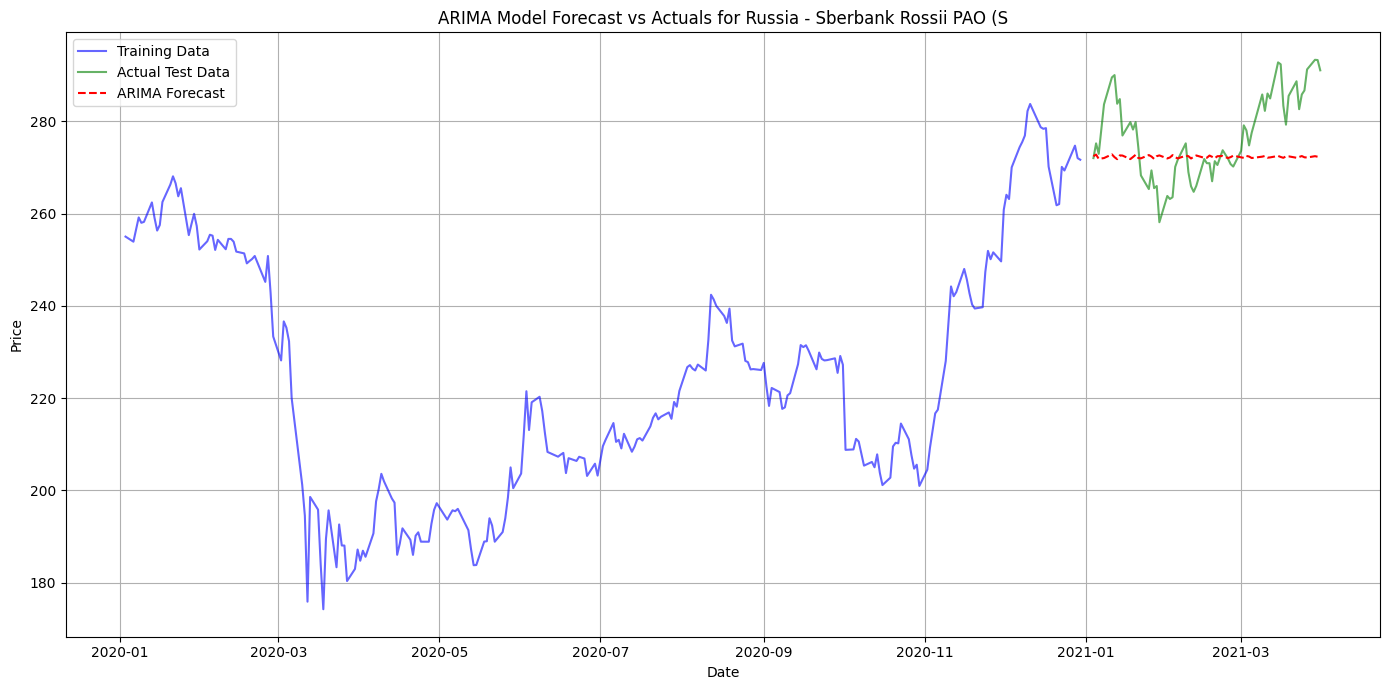

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: Turkey - Koc Holding AS (KCHOL)
Root Mean Squared Error (RMSE): 1.3917705977729935


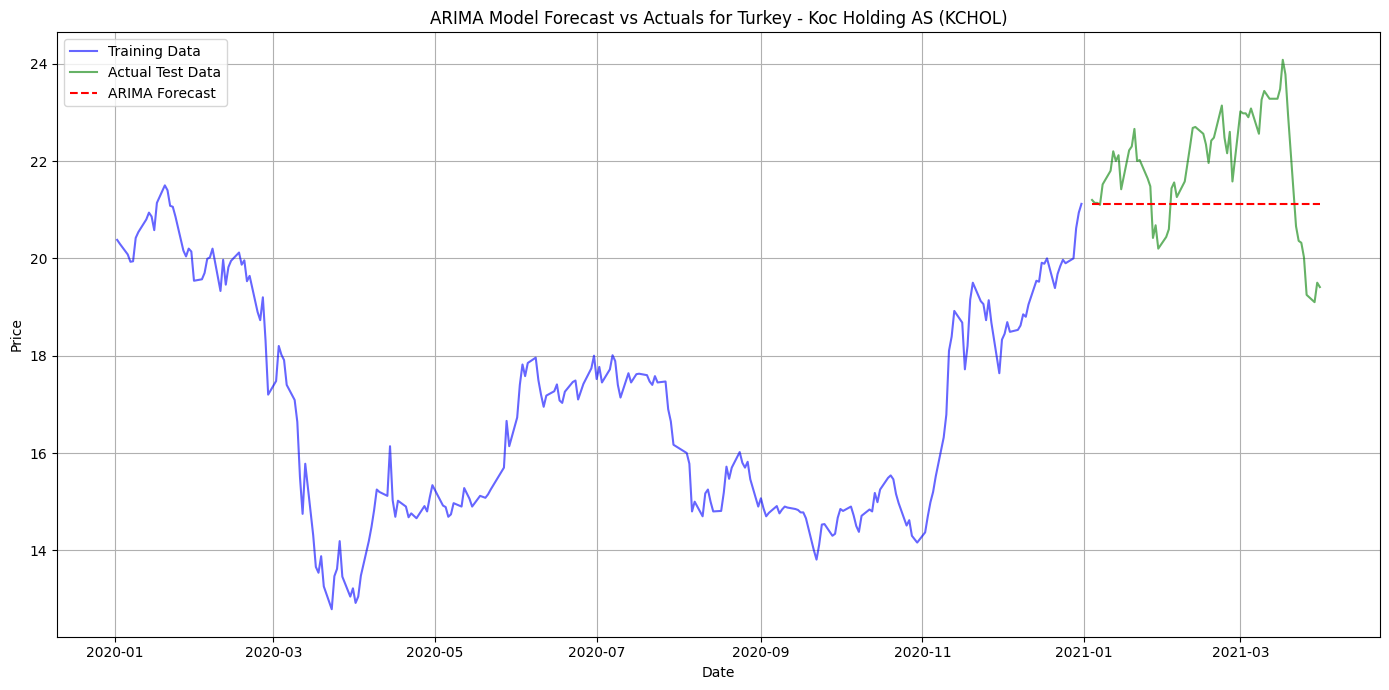

In [ ]:
#!pip install --upgrade statsmodels
# Loop through each row in results_df
for index, row in results_df.iterrows():
    company_name = row['Company']
    best_order = row['Best_Order']

    # Use the train_test_company function for each company
    train_test_company(company_name, train, test, *best_order)

ARIMA Model Using Out-of-Time Cross validation

#**LSTM Model**

In [ ]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse') #compile the model
    return model

In [ ]:
def train_lstm_model(company_name, train, model):
    # Filter and preprocess the data
    train_data = train[train['Company'] == company_name]['Price'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler()
    train_data_normalized = scaler.fit_transform(train_data)

    # Create sequences
    X_train = []
    y_train = []
    for i in range(60, len(train_data_normalized)):  # Using a sequence length of 60
        X_train.append(train_data_normalized[i-60:i, 0])
        y_train.append(train_data_normalized[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    return model, scaler


**Model Evaluation**

In [ ]:
def predict_and_plot(company_name, train, test, model, scaler):
    # Filter and preprocess the data
    train_data = train[train['Company'] == company_name]['Price'].values.reshape(-1, 1)
    test_data = test[test['Company'] == company_name]['Price'].values.reshape(-1, 1)

    # Combine train and test data and normalize
    combined_data = np.concatenate((train_data, test_data), axis=0)
    combined_data_normalized = scaler.transform(combined_data)

    # Create sequences for test data
    X_test = []
    for i in range(len(train_data), len(combined_data)):
        X_test.append(combined_data_normalized[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Predict
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(combined_data, color='blue', label='Actual Prices')
    plt.plot(np.arange(len(train_data), len(combined_data)), predicted_prices, color='red', linestyle='--', label='LSTM Predictions')
    plt.title(f'LSTM Predictions vs Actual Prices for {company_name}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2/2 [==============================] - 0s 23ms/step


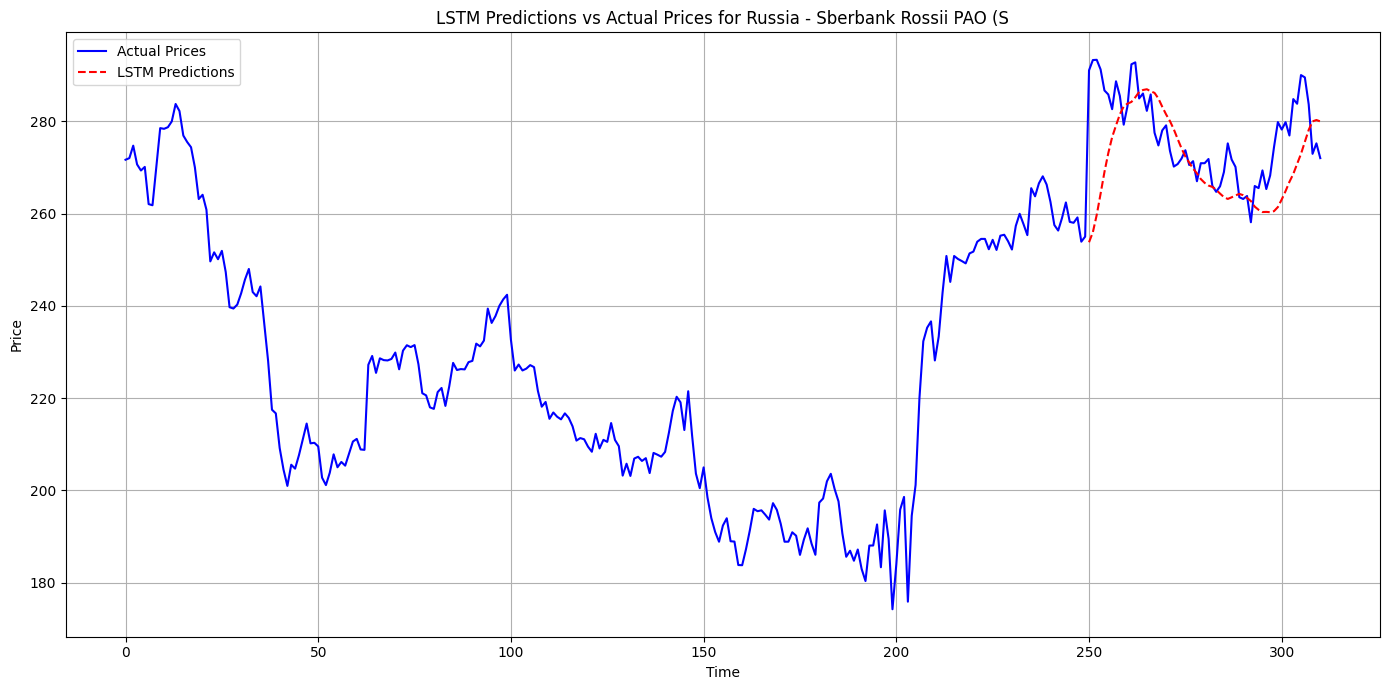

2/2 [==============================] - 1s 20ms/step


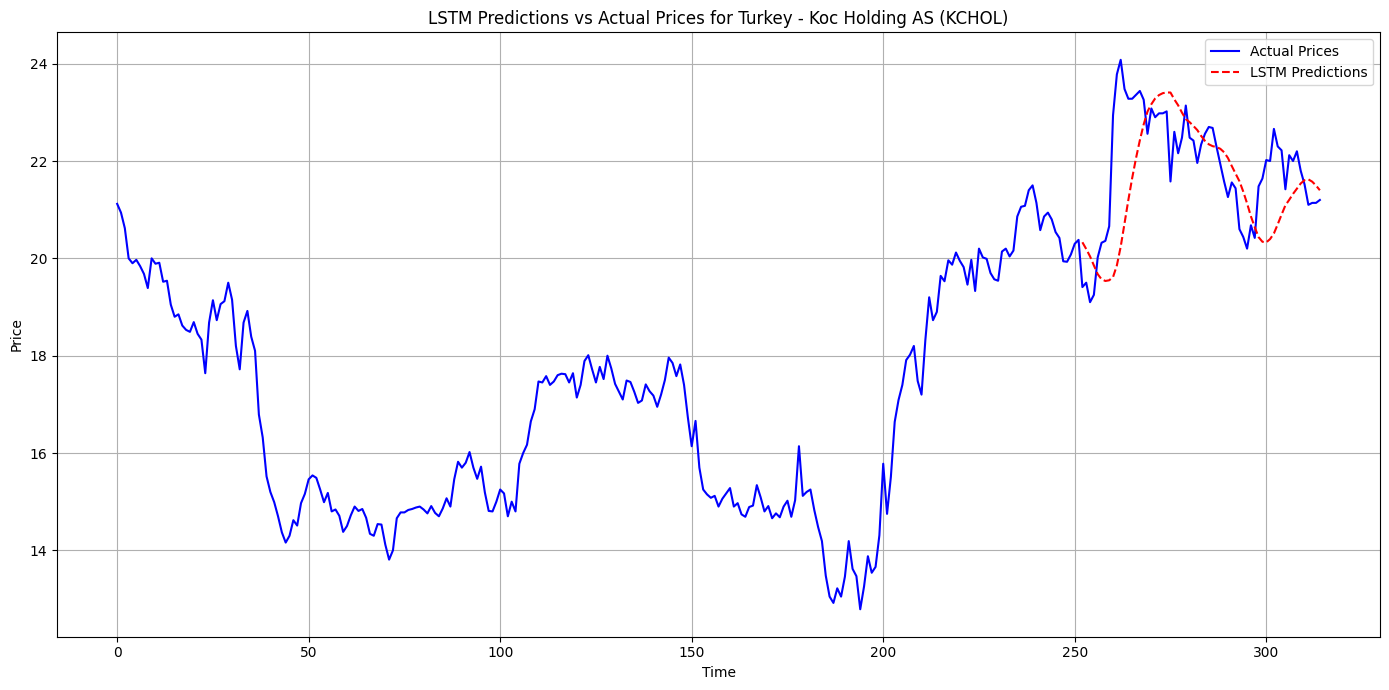

In [ ]:
# For all companies
for company in train['Company'].unique():

  #if len(companies) >= 2:
       # break
    # Generate the model
  input_shape = (60, 1)  # 60 time steps with 1 feature
  model = lstm_model(input_shape)

    # Train the model
  model, scaler = train_lstm_model(company, train, model)

    # Predict and plot
  predict_and_plot(company, train, test, model, scaler)

  #companies.append(company)

#Prophet Model

In [ ]:
###!pip install prophet
#!pip install yfinance


Importing the Libraries

In [ ]:
#IMPORTING ALL THE NECESSARY PACKAGES.
import matplotlib.pyplot as plt                                                 #Importing matplotlib to plot and analyse data.
import pandas as pd
import plotly.express as px
from prophet import Prophet                                                   #Importing prophet (prediction and forecasting library.)
import yfinance as yf

from sklearn.metrics import mean_absolute_error

The YFinance is an API tool that  the ticker name, start time, and end time as parameters and will return the historical data of that stock between the defined period.

In [ ]:
#import dataset for one company
data =pd.read_csv('/content/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv',skipfooter=1, engine='python')

data.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294.00,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.50,38.81M,-0.02%
2,"Mar 29, 2021",293.30,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.50,287.03,283.85,35.22M,0.30%


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      311 non-null    object 
 1   Price     311 non-null    float64
 2   Open      311 non-null    float64
 3   High      311 non-null    float64
 4   Low       311 non-null    float64
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    object 
dtypes: float64(4), object(3)
memory usage: 17.1+ KB


In [ ]:
#covert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
#visualize price
fig = px.line(data, x='Date', y='Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
#prepare the data
#Prophet requires specific column names ('ds' for dates and 'y' for the target variable).
data = data.rename(columns={'Date': 'ds', 'Price': 'y'})



In [ ]:
#create and fit the models
#models = {}
#for company in desired_companies['Company'].unique():
 #   company_data = desired_companies[desired_companies['Company'] == company]
  #  model = Prophet(daily_seasonality=True,yearly_seasonality=True)
   # model.fit(company_data)
    #models[company] = model




In [ ]:
# Split the data into training and test sets
train_data = data[data['ds'].dt.year == 2020]
test_data = data[data['ds'].dt.year == 2021]

print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (250, 7)
testing data size : (61, 7)


In [ ]:
#Model training
model = Prophet(daily_seasonality=True)
model.fit(train_data)
y_actual = test_data['y']

prediction = model.predict(pd.DataFrame({'ds':test_data['ds']}))
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkk0naxc8/elmcs56t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkk0naxc8/jc9qy3vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46994', 'data', 'file=/tmp/tmpkk0naxc8/elmcs56t.json', 'init=/tmp/tmpkk0naxc8/jc9qy3vt.json', 'output', 'file=/tmp/tmpkk0naxc8/prophet_modelh5wqf3bw/prophet_model-20230923061447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


46.7816393442623

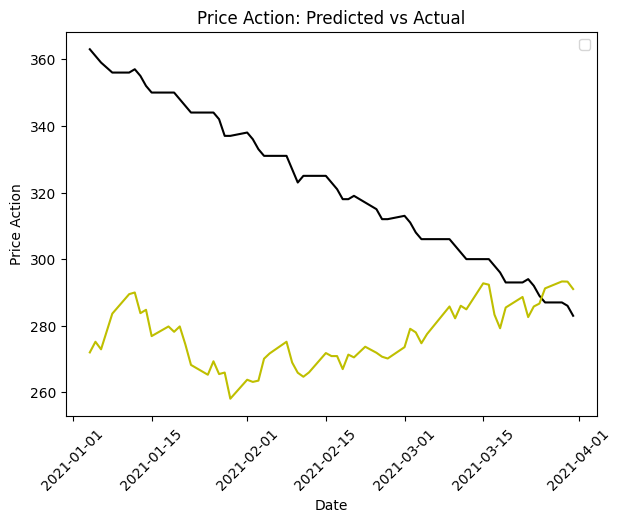

In [ ]:
#visualize the predicted and actual values
plt.plot(test_data['ds'], y_predicted, 'k')
plt.plot(test_data['ds'], y_actual, 'y')
plt.xlabel("Date")
plt.ylabel("Price Action")
plt.title("Price Action: Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds        yhat  yhat_lower  yhat_upper
56 2021-03-25  356.593389  329.912779  383.739686
57 2021-03-26  356.664092  329.817531  382.542848
58 2021-03-29  359.051244  330.427891  388.333093
59 2021-03-30  361.504327  333.121358  389.113842
60 2021-03-31  363.285661  333.523817  392.504427


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkk0naxc8/92x_h_1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkk0naxc8/enr6mzio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48815', 'data', 'file=/tmp/tmpkk0naxc8/92x_h_1f.json', 'init=/tmp/tmpkk0naxc8/enr6mzio.json', 'output', 'file=/tmp/tmpkk0naxc8/prophet_modelfsr6aoj6/prophet_model-20230923061456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


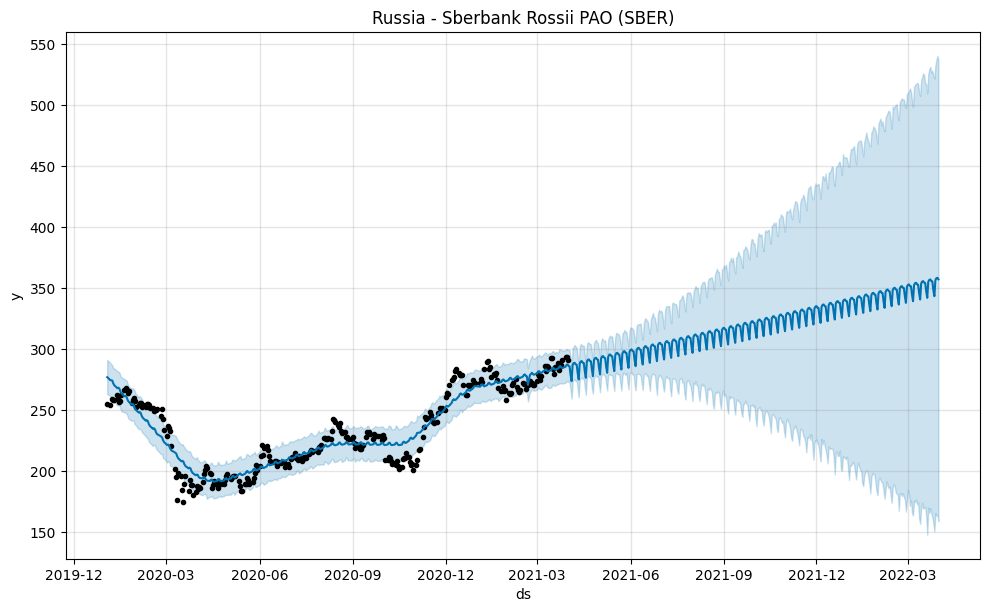

In [ ]:
#Price Action Prediction
model = Prophet()                                                               #creating an instant of prophet class in model.
model.fit(data)                                                           #fitting data_frame to the model.
future = model.make_future_dataframe(365)                                       #making future dataframe for 365 days and storing the date values in future.
forecast = model.predict(future)                                                #using predict function of python, predicting the values for future data values and storing it in forecast.
model.plot(forecast)
plt.title('Russia - Sberbank Rossii PAO (SBER)')                                                            #plotting the values in forecast using atplotlib.
plt.show()

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail())

            ds        yhat  yhat_lower  yhat_upper
671 2022-03-27  343.175234  150.320287  521.592844
672 2022-03-28  356.369630  165.362094  532.458941
673 2022-03-29  357.928604  163.165597  537.047650
674 2022-03-30  358.246480  163.788673  540.154859
675 2022-03-31  356.995925  158.615823  536.691396
